In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.decomposition import PCA
import seaborn as sns

In [3]:
invoice=pd.read_csv("/content/drive/My Drive/Capstone Project/Clean_Invoice.csv")
invoice.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Cust Type,Customer No.,Gate Pass Time,Invoice No,Job Card No,KMs Reading,Make,Model,ODN No.,Order Type,Pin code,Plant,Plant Name1,Print Status,Recovrbl Exp,Regn No,Technician Name,Total Value,User ID,Invoice_DateTime,JobCard_DateTime,Service_Time,Clean_CITY,Clean_District,Clean_Location_Area,Year
0,Retail,67849,00:00:00,7005200002,168303,49317,GENERAL MOTORS,SPARK,7.005200e+09,Paid Service,400601,BC01,THANE,NO,0.0,KA19MA1291,RUPESH,4051.95,BC01FS1,2015-01-02 11:30:36,2014-12-13 14:29:43,19 days 21:00:53.000000000,Thane,Maharashtra,"Thane H.O, Thane Bazar, Thane R.S.",2015
1,Retail,84419,00:00:00,7005200003,173997,78584,TATA MOTORS,INDICA,7.005200e+09,SMC Value Package,400603,BC01,THANE,NO,0.0,MH43R3046,PRASHANT,1001.29,BC01SA2,2015-01-03 10:07:32,2015-01-02 14:12:18,0 days 19:55:14.000000000,Thane,Maharashtra,"Thane East, Kopri Colony",2015
2,Retail,81055,00:00:00,7005200004,173889,33985,MARUTI SUZUKI,ZEN,7.005200e+09,Running Repairs,400607,BC01,THANE,NO,0.0,AP09AX0582,IMRAN,233.14,BC01SA2,2015-01-03 11:12:57,2015-01-02 11:40:44,0 days 23:32:13.000000000,Thane,Maharashtra,"Chitalsar Manpada, Sandozbaugh",2015
3,Retail,84419,00:00:00,7005200005,174158,78584,TATA MOTORS,INDICA,7.005200e+09,SMC Redemption,400603,BC01,THANE,NO,0.0,MH43R3046,PRASHANT,0.00,BC01SA2,2015-01-03 11:40:44,2015-01-03 10:12:32,0 days 01:28:12.000000000,Thane,Maharashtra,"Thane East, Kopri Colony",2015
4,Retail,18980,00:00:00,7005200006,173860,50057,HYUNDAI,SANTRO XING,7.005200e+09,Paid Service,400603,BC01,THANE,NO,0.0,MH04CD9768,DAYANAND,2747.12,BC01SA2,2015-01-03 12:07:17,2015-01-02 10:45:42,1 days 01:21:35.000000000,Thane,Maharashtra,"Thane East, Kopri Colony",2015


In [4]:
invoice.shape

(492314, 26)

#### Dropping unnecesary columns 

In [0]:
invoice.drop(["Regn No","Technician Name"],1,inplace=True)

In [6]:
invoice.isnull().shape

(492314, 24)

#### Calculating the Service Time using Job Card Time and Invoice Time

In [0]:
invoice["Invoice_DateTime"]=pd.to_datetime(invoice["Invoice_DateTime"])
invoice["JobCard_DateTime"]=pd.to_datetime(invoice["JobCard_DateTime"])
invoice["Service_Time"]=invoice["Invoice_DateTime"]-invoice["JobCard_DateTime"]

In [0]:
invoice["Service_Time_Hours"]=invoice["Service_Time"]/np.timedelta64(1, 'h')

In [10]:
customer=pd.read_excel("/content/drive/My Drive/Capstone Project/Customer_Data.xlsx")
customer.head()

,Business Partner,Customer No.,Partner Type,Data Origin,Title,Marital Status,Occupation,Date of Birth,Death date
0,31,1,1.0,Z001,NaN,NaN,NaN,NaN,NaT
1,32,2,1.0,Z005,NaN,NaN,NaN,NaN,NaT
2,34,4,1.0,Z005,NaN,2.0,NaN,NaN,NaT
3,35,5,1.0,Z005,NaN,NaN,NaN,NaN,NaT
4,42,7,1.0,Z008,NaN,NaN,NaN,NaN,NaT


#### Dropping columns containing more than 70% missing values

In [0]:
customer.drop(['Marital Status', 'Occupation', 'Date of Birth', 'Death date', 'Business Partner'],1,inplace=True)

In [12]:
customer.isnull().sum()

Customer No.        0
Partner Type       78
Data Origin       136
Title           46307
dtype: int64

In [0]:
customer['Partner Type'] = customer['Partner Type'].fillna(customer['Partner Type'].mode()[0])
customer['Data Origin'] = customer['Data Origin'].fillna(customer['Data Origin'].mode()[0])
customer['Title'] = customer['Title'].fillna(customer['Title'].mode()[0])

#### Merging Customer and Invoice DataFrame by removing trailing zeros from "Customer No." column of Invoice DataFrame

In [0]:
invoice['Customer No.'] = invoice['Customer No.'].str.lstrip('0')

In [0]:
customer['Customer No.'] = customer['Customer No.'].astype(str)

In [0]:
invoice_customer = pd.merge(invoice, customer, on='Customer No.')

In [17]:
invoice_customer.shape

(492312, 28)

#### Eliminating rows with null values

In [0]:
invoice_customer=invoice_customer[invoice_customer["Total Value"].notnull()]

In [0]:
invoice_customer=invoice_customer[invoice_customer["Clean_CITY"].notnull()]

In [0]:
invoice_customer=invoice_customer[invoice_customer["Model"].notnull()]

In [21]:
jtd=pd.read_csv("/content/drive/My Drive/Capstone Project/JTD.csv")
jtd.head()

,Unnamed: 0,DBM Order,Order Item,Material,Labor Value Number,Description,Item Category,Order Quantity,Target quantity UoM,Net value
0,0,22385,180,OSLCC_SRV31,NaN,MACHINING RR.SUSPENSION CHARGE (MAJOR),P010,1.2,MIN,1869.87
1,1,23910,10,1DM279018170117,NaN,ASSY.OIL COOLER (6-PLATE) (VOR,P002,1.0,EA,2151.13
2,2,23910,40,1IS150203BE01,NaN,FRONT WHEEL BEARING/ LUBRICATE,P002,1.0,EA,2552.92
3,3,23910,60,1DM279001990173,NaN,ASSY.CYL.HEAD W /O INJ.(NA W /O,P002,1.0,EA,20360.14
4,4,23910,70,1DM88552790S001SA,NaN,Engine Overhaul Kit -Indica Di,P002,1.0,EA,10691.63


In [22]:
jtd.isnull().sum()

Unnamed: 0                   0
DBM Order                    0
Order Item                   0
Material                 51629
Labor Value Number     3774033
Description              51629
Item Category                0
Order Quantity               0
Target quantity UoM      51629
Net value                    0
dtype: int64

#### Removing columns containing more than 70% missing values

In [0]:
jtd.drop(["Unnamed: 0","Labor Value Number"],1,inplace=True)

In [0]:
jtd=jtd[jtd["Material"].notnull()]

In [25]:
list(jtd)

['DBM Order',
 'Order Item',
 'Material',
 'Description',
 'Item Category',
 'Order Quantity',
 'Target quantity UoM',
 'Net value']

In [26]:
jtd.shape

(5567855, 8)

#### Performing group by on "DBM Order" and "Item Category" column of JTD DataFrame to reduce the multiple entries based on same 'DBM Order"

In [0]:
jtd_group=jtd.groupby(["DBM Order","Item Category"]).agg({"Net value":'mean',"Order Quantity":"mean"})

#### Mergining all three DataFrames 

In [0]:
invoice_customer_jtd=pd.merge(invoice_customer,jtd_group,left_on="Job Card No",right_on="DBM Order")

In [29]:
invoice_customer_jtd.head()

,Cust Type,Customer No.,Gate Pass Time,Invoice No,Job Card No,KMs Reading,Make,Model,ODN No.,Order Type,Pin code,Plant,Plant Name1,Print Status,Recovrbl Exp,Total Value,User ID,Invoice_DateTime,JobCard_DateTime,Service_Time,Clean_CITY,Clean_District,Clean_Location_Area,Year,Service_Time_Hours,Partner Type,Data Origin,Title,Net value,Order Quantity
0,Retail,67849,00:00:00,7005200002,168303,49317,GENERAL MOTORS,SPARK,7.005200e+09,Paid Service,400601,BC01,THANE,NO,0.0,4051.95,BC01FS1,2015-01-02 11:30:36,2014-12-13 14:29:43,19 days 21:00:53,Thane,Maharashtra,"Thane H.O, Thane Bazar, Thane R.S.",2015,477.014722,1.0,Z007,2.0,601.570000,36.500
1,Retail,67849,00:00:00,7005200002,168303,49317,GENERAL MOTORS,SPARK,7.005200e+09,Paid Service,400601,BC01,THANE,NO,0.0,4051.95,BC01FS1,2015-01-02 11:30:36,2014-12-13 14:29:43,19 days 21:00:53,Thane,Maharashtra,"Thane H.O, Thane Bazar, Thane R.S.",2015,477.014722,1.0,Z007,2.0,587.187500,1.625
2,Retail,67849,00:00:00,7005200002,168303,49317,GENERAL MOTORS,SPARK,7.005200e+09,Paid Service,400601,BC01,THANE,NO,0.0,4051.95,BC01FS1,2015-01-02 11:30:36,2014-12-13 14:29:43,19 days 21:00:53,Thane,Maharashtra,"Thane H.O, Thane Bazar, Thane R.S.",2015,477.014722,1.0,Z007,2.0,500.060000,1.000
3,Retail,67849,00:00:00,7000137359,136482,45575,GENERAL MOTORS,SPARK,7.000137e+09,Accidental,400601,BC01,THANE,NO,0.0,11470.10,BC01FS1,2014-08-14 17:54:30,2014-08-08 15:26:53,6 days 02:27:37,Thane,Maharashtra,"Thane H.O, Thane Bazar, Thane R.S.",2014,146.460278,1.0,Z007,2.0,494.990000,1000.000
4,Retail,67849,00:00:00,7000137359,136482,45575,GENERAL MOTORS,SPARK,7.000137e+09,Accidental,400601,BC01,THANE,NO,0.0,11470.10,BC01FS1,2014-08-14 17:54:30,2014-08-08 15:26:53,6 days 02:27:37,Thane,Maharashtra,"Thane H.O, Thane Bazar, Thane R.S.",2014,146.460278,1.0,Z007,2.0,604.321429,1.000


#### Choosing columns required for Clustering 

In [0]:
invoice_cluster=invoice_customer_jtd.groupby(["Customer No.","Make","Model","Clean_Location_Area","Cust Type"]).agg({"Total Value":'mean',"Invoice No":'count',"Service_Time_Hours":'mean'}).reset_index()

In [31]:
invoice_cluster.isnull().sum()

Customer No.           0
Make                   0
Model                  0
Clean_Location_Area    0
Cust Type              0
Total Value            0
Invoice No             0
Service_Time_Hours     0
dtype: int64

In [32]:
invoice_cluster.dtypes

Customer No.            object
Make                    object
Model                   object
Clean_Location_Area     object
Cust Type               object
Total Value            float64
Invoice No               int64
Service_Time_Hours     float64
dtype: object

In [33]:
invoice_cluster.shape

(129452, 8)

#### Label Encoding Categorical Columns 

In [0]:
le=LabelEncoder()
invoice_cluster["Make"]=le.fit_transform(invoice_cluster["Make"])
invoice_cluster["Model"]=le.fit_transform(invoice_cluster["Model"])
invoice_cluster["Clean_Location_Area"]=le.fit_transform(invoice_cluster["Clean_Location_Area"])
invoice_cluster["Cust Type"]=le.fit_transform(invoice_cluster["Cust Type"])

In [0]:
X=invoice_cluster.drop(["Customer No."],1)

In [0]:
std=StandardScaler()

#### Standard Scaling all the features for K-Means Clustering 

In [0]:
X=std.fit_transform(X)

#### Calculating WCSS score for different Number of clusters 

In [0]:
wcss=[]
for i in range(2,11):
    clf=KMeans(n_clusters=i,random_state=42)
    clf.fit(X)
    wcss.append(clf.inertia_)

Text(0.5, 0, 'Number of Clusters')

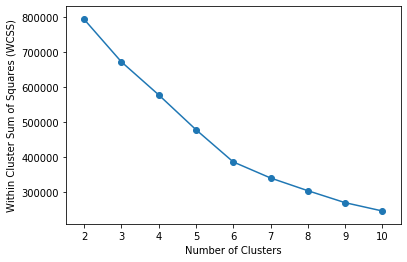

In [39]:
x=np.arange(2,11)
plt.plot(x,wcss)
plt.scatter(x,wcss)
plt.ylabel("Within Cluster Sum of Squares (WCSS)")
plt.xlabel("Number of Clusters")

#### Calculating Silhouette Score for different number of Clusters 

In [0]:
sil=[]
for j in range(2,11):
    kmeans=KMeans(n_clusters=j,init='k-means++',random_state=42)
    kmeans.fit(X)
    labels=kmeans.labels_
    centroids=kmeans.cluster_centers_
    sil.append(silhouette_score(X, labels, metric='euclidean'))

Text(0, 0.5, 'Silhouette Score')

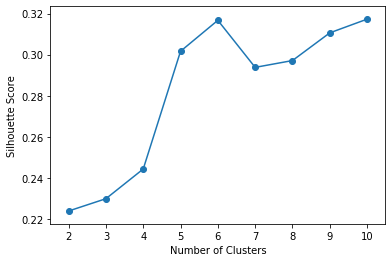

In [41]:
x=np.arange(2,11)
plt.plot(x,sil)
plt.scatter(x,sil)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")

#### Final K-Means model with number of Clusters as 6

In [0]:
clf_final=KMeans(n_clusters=6,random_state=42)

In [43]:
clf_final.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [0]:
invoice_cluster["Clusters"]=clf_final.predict(X)

#### Representation of Final Clusters 

In [45]:
invoice_cluster["Cust Type"]=le.inverse_transform(invoice_cluster["Cust Type"])
invoice_cluster.groupby(["Clusters","Cust Type"]).agg({"Total Value":"mean","Service_Time_Hours":'mean',"Customer No.":'count'}).sort_values(by='Total Value')

Total Value  Service_Time_Hours  Customer No.
Clusters Cust Type                                                        
1        MFCWL               3568.611448           67.293009            22
0        MFCWL               3740.269223           82.263743            13
3        Retail              3908.193282           52.404077         47918
0        Retail              4020.331974           60.596416         24721
1        Retail              4141.941868           50.930573         54501
3        Insurance           4235.490000           48.614722             1
         MFCWL               4256.825202           69.319450            28
4        Fleets              5113.983196           37.474696             1
         Retail              5584.876050           80.921890             1
2        Corporate others    7488.756510           89.715386           102
         Fleets              8089.509474          157.846242            98
         Corporate- M&M     17290.994258          194.564308            36
5        Retail             55172.300736         1115.566490          2009
         Fleets            120606.951765         5483.763742             1

In [0]:
pca=PCA(n_components=2)

In [0]:
invoice_cluster['x']=pca.fit_transform(X)[:,0]
invoice_cluster['y']=pca.fit_transform(X)[:,1]

#### Representing Final Clusters in a graph using PCA

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:576: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


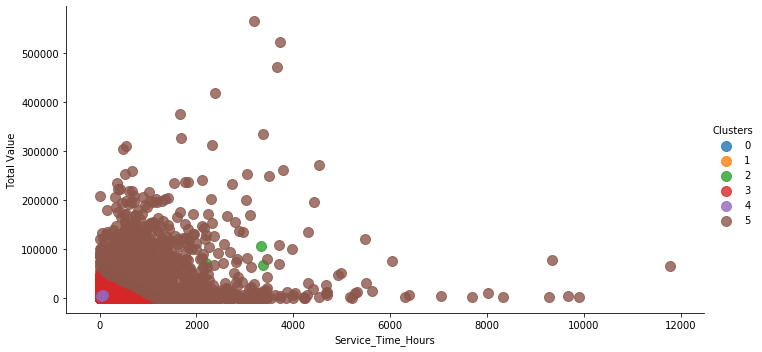

In [48]:
sns.lmplot(data=invoice_cluster,x="Service_Time_Hours", y="Total Value", hue='Clusters', fit_reg=False, legend=True, legend_out=True,size=5,aspect=2,scatter_kws={"s": 100})